In [2]:
import ising
import importlib
importlib.reload(ising)
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from tqdm import tqdm
import seaborn as sns

In [22]:
noisy_images = np.load('data/noisy_images_fashion_mnist.npy')
cleaned_images = np.load('data/fashion_mnist_denoised.npy')

df = pd.read_csv('data/fashion-mnist_test.csv')
labels = df['label'].values
df.drop(columns=['label'], inplace=True)
df = df.values.reshape(-1, 28, 28)
# convert to binary values
binary_images = np.where(df < 128, -1, 1)

In [ ]:
def dice_score(pred: np.ndarray, target: np.ndarray) -> float:
    pred = pred.flatten()
    target = target.flatten()

    # Zamień -1 → 1, 1 → 0
    pred = (pred == -1).astype(np.uint8)
    target = (target == -1).astype(np.uint8)

    intersection = np.sum(pred & target)
    total = np.sum(pred) + np.sum(target)

    if total == 0:
        return 1.0  # Obie maski puste

    return 2.0 * intersection / total

In [12]:
noisy = noisy_images[0]
cleaned = cleaned_images[0]
magnetized_img = binary_images[0]

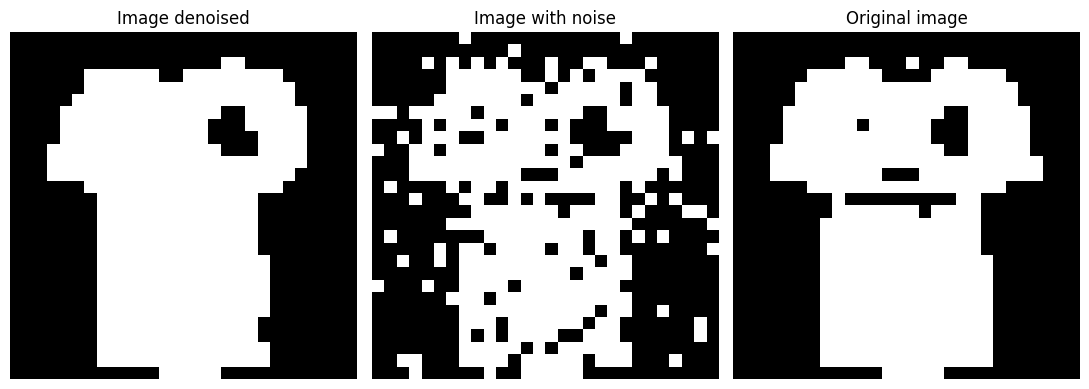

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(11, 6))
axes[0].imshow(cleaned, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[0].set_title("Image denoised")
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].set_title("Image with noise")
axes[2].imshow(magnetized_img, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[2].set_title("Original image")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [19]:
dice_denoised = dice_score(cleaned, magnetized_img)
dice_noisy = dice_score(noisy, magnetized_img)

print(f"Dice score (denoised vs original): {dice_denoised:.4f}")
print(f"Dice score (noisy vs original):    {dice_noisy:.4f}")

Dice score (denoised vs original): 0.9652
Dice score (noisy vs original):    0.8905


# Noisiness vs DICE

## Small noisiness parameter in the chain

In [23]:
def add_flip_noise(image: np.ndarray, q: float = 0.9, show: bool = False) -> np.ndarray:
    if not np.all(np.isin(image, [-1, 1])):
        raise ValueError("Obraz musi zawierać tylko wartości -1 i 1.")

    noise = np.random.random(size=image.shape) > q  # True tam, gdzie odwracamy
    noisy = np.array(image, copy=True)
    noisy[noise] = -noisy[noise]

    if show:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes.imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
        axes.set_title(f"Obraz z szumem (q={q})")
        axes.axis("off")
        plt.show()

    return noisy

In [ ]:
q_values = [0.5,0.75,0.9, 0.95]
total_images = len(binary_images)

num_images = 200
selected_indices = np.random.choice(total_images, size=num_images, replace=False)

In [ ]:
results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    # image, info = load_image(idx)
    magnetized, label = binary_images[idx], labels[idx]

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising.IsingDeNoise(noisy, 0.9)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "label": label,
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)

Processing images:   0%|          | 0/200 [00:00<?, ?it/s]

Processing images: 100%|██████████| 200/200 [1:47:10<00:00, 32.15s/it]


In [25]:
df_results

,label,q,denoised_dice,noise_dice
0,1,0.50,0.333755,0.563107
1,1,0.75,0.919008,0.813820
2,1,0.90,0.948109,0.927985
3,1,0.95,0.948109,0.953321
4,3,0.50,0.707934,0.567511
...,...,...,...,...
795,9,0.95,0.938000,0.947477
796,4,0.50,0.562607,0.461103
797,4,0.75,0.908497,0.704142
798,4,0.90,0.921797,0.870370


In [ ]:
# df_results.to_csv("ising_denoising_results.csv", index=False)

In [ ]:
def plot_dice_boxplots(df, highlight_q=0.9):
    df = df.copy()
    df["improvement"] = df["denoised_dice"] - df["noise_dice"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.boxplot(data=df, x="q", y="denoised_dice", ax=axes[0])
    axes[0].set_title("Denoised Dice vs q")
    axes[0].set_xlabel("q")
    axes[0].set_ylabel("Dice score")
    axes[0].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    sns.boxplot(data=df, x="q", y="noise_dice", ax=axes[1])
    axes[1].set_title("Noisy Dice vs q")
    axes[1].set_xlabel("q")
    axes[1].set_ylabel("")
    axes[1].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    sns.boxplot(data=df, x="q", y="improvement", ax=axes[2])
    axes[2].set_title("Improvement (denoised - noisy) vs q")
    axes[2].set_xlabel("q")
    axes[2].set_ylabel("")
    axes[2].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

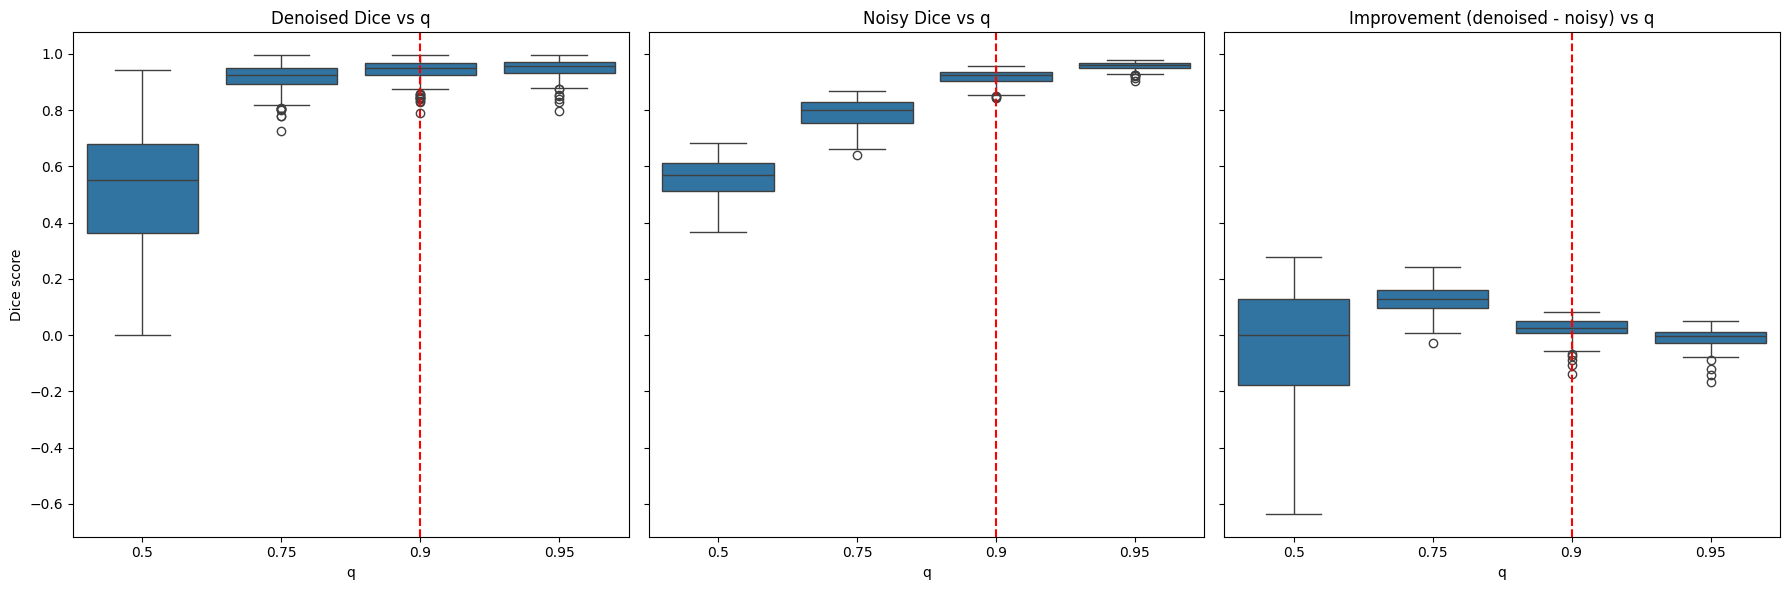

In [28]:
plot_dice_boxplots(df_results)

## Big noisiness parameter in the chain

In [ ]:
results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    # image, info = load_image(idx)
    magnetized, label = binary_images[idx], labels[idx]

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising.IsingDeNoise(noisy, 0.75)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "label": label,
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)

Processing images: 100%|██████████| 200/200 [2:42:43<00:00, 48.82s/it]     


In [ ]:
# df_results.to_csv("ising_denoising_results_small_q.csv", index=False)

In [ ]:
# df_results = pd.read_csv("ising_denoising_results_small_q.csv")

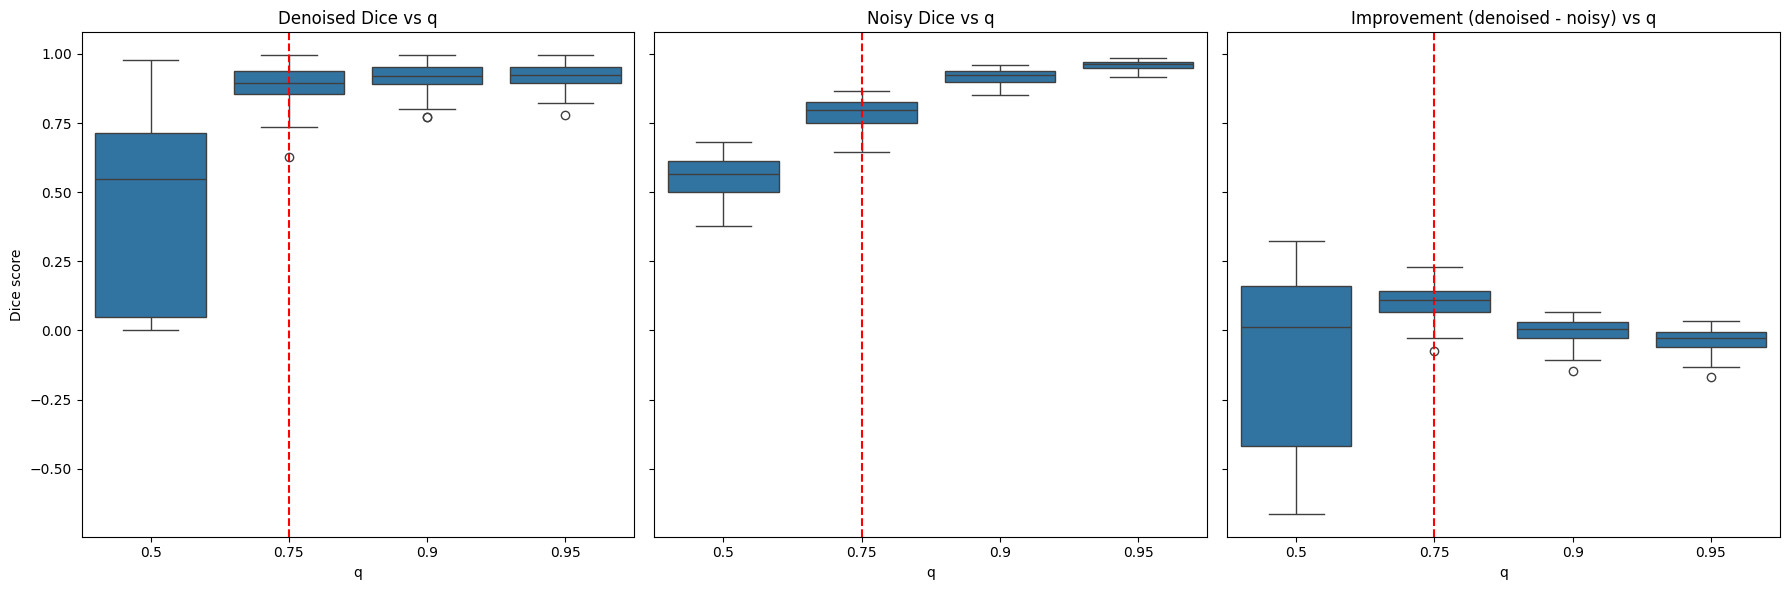

In [32]:
plot_dice_boxplots(df_results, highlight_q=0.75)

# Testing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

def test_distribution(df, column="denoised_dice", alpha=0.05, plot=True):
    results = []
    for q_val in sorted(df["q"].unique()):
        subset = df[df["q"] == q_val][column]
        stat, p_value = shapiro(subset)
        normality = p_value > alpha
        results.append({
            "q": q_val,
            "statistic": stat,
            "p_value": p_value,
            "normality": normality
        })

    res_df = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(8,5))
        sns.barplot(data=res_df, x="q", y="p_value", color="steelblue")

        plt.axhline(alpha, color="red", linestyle="--", label=f"Poziom istotności ({alpha})")

        for i, row in res_df.iterrows():
            if not row["normality"]:
                plt.gca().patches[i].set_alpha(0.4)

        plt.title(f"Test Shapiro-Wilka dla kolumny '{column}'")
        plt.ylabel("p-value")
        plt.xlabel("q")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return res_df

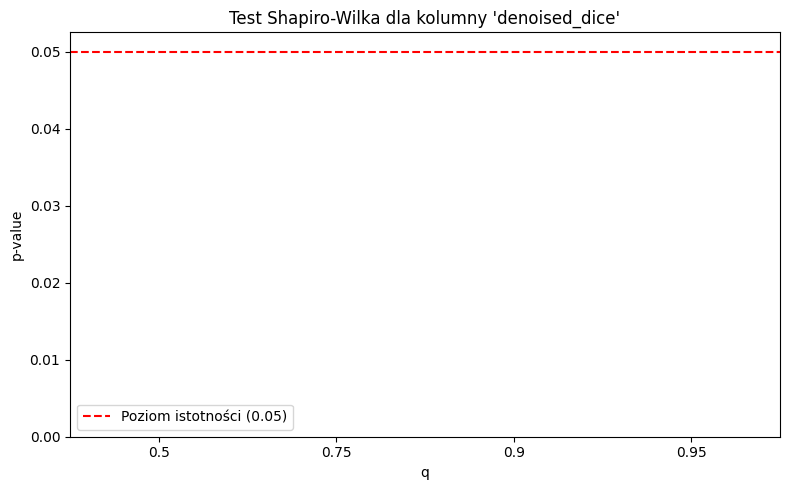

,q,statistic,p_value,normality
0,0.50,0.956567,8.559696e-06,False
1,0.75,0.934839,8.346639e-08,False
2,0.90,0.903219,4.048754e-10,False
3,0.95,0.902055,3.403086e-10,False


In [5]:
df_1 = pd.read_csv("ising_denoising_results.csv")
test_distribution(df_1)

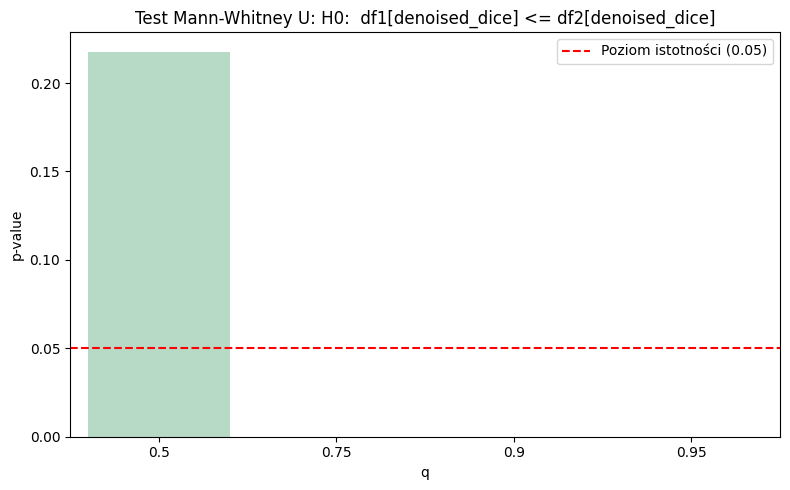

      q  statistic       p_value  higher_in_df1
0  0.50    20900.5  2.177639e-01          False
1  0.75    25155.0  4.129127e-06           True
2  0.90    27002.5  6.961328e-10           True
3  0.95    27973.5  2.669934e-12           True


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def wilcoxon_compare(df1, df2, column="denoised_dice", alpha=0.05, plot=True):
    results = []

    q_values = sorted(set(df1["q"]).intersection(df2["q"]))

    for q_val in q_values:
        group1 = df1[df1["q"] == q_val][column]
        group2 = df2[df2["q"] == q_val][column]

        stat, p_value = mannwhitneyu(group1, group2, alternative="greater")

        results.append({
            "q": q_val,
            "statistic": stat,
            "p_value": p_value,
            "higher_in_df1": p_value < alpha
        })

    res_df = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(8,5))
        sns.barplot(data=res_df, x="q", y="p_value", color="mediumseagreen")

        plt.axhline(alpha, color="red", linestyle="--", label=f"Poziom istotności ({alpha})")

        # Półprzezroczystość słupków z brakiem istotności
        for i, row in res_df.iterrows():
            if not row["higher_in_df1"]:
                plt.gca().patches[i].set_alpha(0.4)

        plt.title(f"Test Mann-Whitney U: H0:  df1[{column}] <= df2[{column}]")
        plt.xlabel("q")
        plt.ylabel("p-value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return res_df

# Przykład użycia:
df1 = pd.read_csv("ising_denoising_results.csv")
df2 = pd.read_csv("ising_denoising_results_small_q.csv")

test_results = wilcoxon_compare(df1, df2, column="denoised_dice", alpha=0.05, plot=True)
print(test_results)
